In [ ]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import itertools
import ast
import pandas as pd
import numpy as np
import torch
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from tqdm import tqdm
import torch.nn as nn

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/temp_manu.csv').drop(columns=['Unnamed: 0'])
df

,GlobalId,Web,Name,Employees,BusinessDescription,DataSource,ContractManufacturer,ProductManufacturer,Industry,Certification,...,City,County,State,Zip,Latitude,Longitude,Phone,Fax,NAICSCode,NAICSDescription
0,['westindiesvalve_dhs'],['www.westindiesvalve.com'],['WEST INDIES VALVE AND MACHINE WORK CORPORATI...,[0.0],[],['DHS'],['No'],['No'],[],['ASME Certificate'],...,['Penuelas'],['Penuelas'],['PR'],[],[18.0054364],[-66.7276429],['(787) 836-1707'],['NOT AVAILABLE'],[332919.0],['OTHER METAL VALVE AND PIPE FITTING MANUFACTU...
1,['101pipe_dhs'],['www.101pipe.com'],"['101 VERTICAL FABRICATION, INC.']",[50.0],[],['DHS'],['No'],['Yes'],[],[],...,['Fontana'],['San Bernardino'],['California'],[],[34.0677902],[-117.4708951],['(909) 428-6000'],['(909) 428-4535'],[332996.0],['FABRICATED PIPE AND PIPE FITTING MANUFACTURI...
2,['149401-us_mskg'],['www.149401-us.all.biz'],['149401-US'],[],[],['MSKG'],['No'],['Yes'],['Transportation Industry'],['ISO 9001 Certificate'],...,[],[],[],[],[],[],[],[],[],[]
3,['1776fabrication_mskg'],['www.1776fabrication.com'],['1776 Fabrication'],[],[],['MSKG'],['Yes'],['Yes'],['Automotive Industry'],[],...,[],[],[],[],[],[],[],[],[],[]
4,['1dietech_mskg'],['www.1dietech.com'],['1Dietech.'],[],[],['MSKG'],['Yes'],['Yes'],"['Automotive Industry', 'Furniture Industry']",['IATF 16949 Certificate'],...,['Carrollton'],[],['Georgia'],[],[33.566767],[-85.078863],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14741,['windigosigns_d&b'],['www.windigosigns.com'],['windigosigns'],[],"['Windigo Signs, Inc. is primarily engaged in ...",['D&B'],['No'],['Yes'],['Aluminum'],[],...,['Tempe'],['Maricopa'],['Arizona'],[],[],[],['1-844-946-3446'],[],[339950.0],['Sign Manufacturing']
14742,['xantusb_d&b'],['www.xantusb.openfos.com'],['xantusb.openfos'],[],['Xantus Business Systems Llc is primarily eng...,['D&B'],['No'],['Yes'],[],[],...,['Sierra Vista'],['Cochise'],['Arizona'],[],[],[],['1-520-459-7809'],[],[323111.0],['Commercial Printing (except Screen and Books)']
14743,['vicivisionamerica_d&b'],['www.vicivisionamerica.com'],['vicivisionamerica'],[],['Vicivision America Llc is primarily engaged ...,['D&B'],['No'],['Yes'],[],[],...,['Scottsdale'],['Maricopa'],['Arizona'],[],[],[],['1-480-212-5172'],[],[333310.0],['Commercial and Service Industry Machinery Ma...
14744,['infineon_d&b'],['www-blue.infineon.com'],['www-blue.infineon'],[],['Infineon Technologies Americas Corp. is prim...,['D&B'],[],[],"['Concrete', 'Lead', 'Titanium']",[],...,"['Mesa', 'Chandler']",['Maricopa'],['Arizona'],[],[],[],"['1-480-655-7701', '1-480-627-5700']",[],[334413.0],['Semiconductor and Related Device Manufacturi...


In [ ]:
df = df[['GlobalId', 'ProcessCapability']]
df

,GlobalId,ProcessCapability
0,['westindiesvalve_dhs'],[]
1,['101pipe_dhs'],[]
2,['149401-us_mskg'],[]
3,['1776fabrication_mskg'],"['Forming Capability', 'Machining Capability',..."
4,['1dietech_mskg'],"['Forming Capability', 'Laser Cutting Capabili..."
...,...,...
14741,['windigosigns_d&b'],[]
14742,['xantusb_d&b'],[]
14743,['vicivisionamerica_d&b'],[]
14744,['infineon_d&b'],[]


In [ ]:
df['GlobalId'].value_counts()

,count
GlobalId,
['net_az'],10
['us_az'],4
['us_d&b'],4
['shop_d&b'],3
['hub_d&b'],3
...,...
['inland-mfg_mskg'],1
['inlandbuildings_dhs'],1
['inlandlakes_dhs'],1


Cleans up the ProcessCapability column by turning the text '[]' into missing values and parsing all other stringified Python literals into real Python data structures

In [ ]:
df['ProcessCapability'] = df['ProcessCapability'].apply(lambda x:None if x=='[]' else ast.literal_eval(x))

<ipython-input-8-5f50d4be1623>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ProcessCapability'] = df['ProcessCapability'].apply(lambda x:None if x=='[]' else ast.literal_eval(x))


In [ ]:
sum(df['ProcessCapability'].isna())

8090

In [ ]:
df.dropna(subset=['ProcessCapability'], inplace=True)
sum(df['ProcessCapability'].isna())

<ipython-input-10-c6a827cafaf7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['ProcessCapability'], inplace=True)


0

In [ ]:
df['ProcessCapability']

,ProcessCapability
3,"[Forming Capability, Machining Capability, Fin..."
4,"[Forming Capability, Laser Cutting Capability,..."
10,"[Wire EDM Capability, Boring Capability, Casti..."
11,"[Grinding Capability, Etching Capability, Bori..."
13,"[Additive Manufacturing Capability, Casting Ca..."
...,...
14723,"[Assembly Automated, Assembly Non-Automated, T..."
14724,"[Prototyping Validation, Assembly Downstream, ..."
14739,"[Welding Robotic, Welding Manual, Assembly Mec..."
14740,"[Co-Packing, Purify, Treat]"


In [ ]:
df['GlobalId']

,GlobalId
3,['1776fabrication_mskg']
4,['1dietech_mskg']
10,['3dimensional_mskg']
11,['3dmach_mskg']
13,['3dsystems_mskg']
...,...
14723,['gillman_d&b']
14724,['accudyn_d&b']
14739,['wildeck_d&b']
14740,['whitewaternow_d&b']


We flatten each row’s list of `ProcessCapability` values into a two-column edge list—one `(GlobalId, capability)` pair per entry—then packages the pairs into a new DataFrame `edge_df`.

In [ ]:
edges = []
for idx, row in df.iterrows():
    gid = row['GlobalId']
    capabilities = row['ProcessCapability']
    for cap in capabilities:
        edges.append((gid, cap))

edge_df = pd.DataFrame(edges, columns=['GlobalId', 'ProcessCapability'])

In [ ]:
edge_df

,GlobalId,ProcessCapability
0,['1776fabrication_mskg'],Forming Capability
1,['1776fabrication_mskg'],Machining Capability
2,['1776fabrication_mskg'],Finishing Capability
3,['1776fabrication_mskg'],Fabricating Capability
4,['1776fabrication_mskg'],CNC Machining Capability
...,...,...
70362,['westfall-technik_d&b'],Prototyping Low-Volume
70363,['westfall-technik_d&b'],Prototyping High-Volume
70364,['westfall-technik_d&b'],Assembly Kitting
70365,['westfall-technik_d&b'],Automation Cell Engineering


We implement labelencoding for the dataframe

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

le_gid = LabelEncoder()
le_cap = LabelEncoder()

edge_df['gid_encoded'] = le_gid.fit_transform(edge_df['GlobalId'])
edge_df['cap_encoded'] = le_cap.fit_transform(edge_df['ProcessCapability'])
edge_df['cap_encoded'] += edge_df['gid_encoded'].max() + 1      #offset capability code so that node IDs in the graph are unique
edge_df

,GlobalId,ProcessCapability,gid_encoded,cap_encoded
0,['1776fabrication_mskg'],Forming Capability,0,9137
1,['1776fabrication_mskg'],Machining Capability,0,10014
2,['1776fabrication_mskg'],Finishing Capability,0,9035
3,['1776fabrication_mskg'],Fabricating Capability,0,8949
4,['1776fabrication_mskg'],CNC Machining Capability,0,7337
...,...,...,...,...
70362,['westfall-technik_d&b'],Prototyping Low-Volume,6475,11358
70363,['westfall-technik_d&b'],Prototyping High-Volume,6475,11355
70364,['westfall-technik_d&b'],Assembly Kitting,6475,6945
70365,['westfall-technik_d&b'],Automation Cell Engineering,6475,7052


Link-prediction (or edge classification) is essentially a binary-classification problem. Positive edges tell the model what a real connection looks like in terms of node features and graph context. Negative edges give counter-examples, preventing the model from simply predicting “edge” for every pair.

In this code snippet, we shuffle known part-capability links, split them 80/20 into training and test positives, then construct matching negative edges—balanced in the test set and smaller in the training set—to create datasets ready for training and evaluating a link-prediction model.

In binary-classification tasks, edges that truly exist (the positive edges) are often vastly out-numbered by negatives (non-edges). If we feed this raw distribution to a model, it can achieve deceptively high accuracy simply by predicting the majority class every time (“no edge here”), yet it will perform poorly on the minority class that we are actually concerned with. Thus we sub-sample the majority class so that the model sees a near mix of samples and is not biased.

In [ ]:
#we create a list of positive edges (existing links) by pairing each encoded part-ID (gid_encoded) with each encoded capability (cap_encoded).
pos_edges = list(zip(edge_df['gid_encoded'], edge_df['cap_encoded']))

#we shuffle the edges in order to reduce biasing
random.shuffle(pos_edges)

#we split it into an 80:20 training and testing set
split = int(len(pos_edges) * 0.8)
train_edges = pos_edges[:split]
test_pos_edges = pos_edges[split:]

#collect the unique sets of gids and capabailities
all_gids = edge_df['gid_encoded'].unique()
all_caps = edge_df['cap_encoded'].unique()

#we generate all possible part-capability pairs (Cartesian product) and remove the ones that actually exist; what remains are candidate negative edges—pairs that are not present in the data.
possible_neg_edges = list(set((g, c) for g in all_gids for c in all_caps) - set(pos_edges))
test_neg_edges = random.sample(possible_neg_edges, len(test_pos_edges))   #randomly select a negative edge equal in size to a positive edge
possible_neg_set = set(possible_neg_edges)
test_neg_set = set(test_neg_edges)

#we remove the test negatives from the overall negative pool, then sample a training-negative set that is half the size of the training-positive set
train_neg_pool = possible_neg_set - test_neg_set
train_neg_edges = random.sample(list(train_neg_pool), len(train_edges) // 2)

In [ ]:
len(train_edges), len(train_neg_edges), len(test_pos_edges), len(test_neg_edges)

(56293, 28146, 14074, 14074)

We convert the raw edge lists into [2,E] tensors (for pytorch to process), create one-hot node features, and build a PyG Data object whose edge_index contains both directions of every training edge, giving an undirected graph that is ready for Graph Neural Network training and later link-prediction evaluation.

In [ ]:
#we turn the list of (source, target) tuples into a tensor of integers
def encode_edges(edge_list):
    return torch.tensor(edge_list, dtype=torch.long).T  # shape [2, num_edges]

#create tensors for every edge
train_edge_index = encode_edges(train_edges)
test_pos_index = encode_edges(test_pos_edges)
test_neg_index = encode_edges(test_neg_edges)
train_neg_index = encode_edges(train_neg_edges)

num_nodes = max(edge_df['cap_encoded'].max(), edge_df['gid_encoded'].max()) + 1  #total number of nodes
x = torch.eye(num_nodes)

#we assemble the training graph
data = Data(x=x, edge_index=torch.cat([train_edge_index, train_edge_index.flip(0)], dim=1))

In [ ]:
data

Data(x=[13147, 13147], edge_index=[2, 112586])

In [ ]:
train_edges[:5]

[(1737, 7115), (863, 7494), (4591, 8949), (1577, 9137), (1478, 10014)]

In [ ]:
train_edge_index

tensor([[1737,  863, 4591,  ..., 4085, 2669, 1599],
        [7115, 7494, 8949,  ..., 8680, 7666, 6921]])

In [ ]:
train_edge_index.shape

torch.Size([2, 56293])

In [ ]:
x

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [ ]:
num_nodes

13147

In [ ]:
edge_df['cap_encoded'].max()

13146

In [ ]:
edge_df['gid_encoded'].max()

6645

In [ ]:
torch.cat([train_edge_index, train_edge_index.flip(0)])

tensor([[1737,  863, 4591,  ..., 4085, 2669, 1599],
        [7115, 7494, 8949,  ..., 8680, 7666, 6921],
        [7115, 7494, 8949,  ..., 8680, 7666, 6921],
        [1737,  863, 4591,  ..., 4085, 2669, 1599]])

In [ ]:
torch.cat([train_edge_index, train_edge_index.flip(0)]).shape

torch.Size([4, 56293])

In [ ]:
x[13146]

tensor([0., 0., 0.,  ..., 0., 0., 1.])

The GCNEncoder is a compact, two-layer Graph Convolutional Network (GCN) that turns raw node features into latent embeddings.

In [ ]:
class GCNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

We instantiate a two-layer GCN to turn node features into 64-dimensional embeddings. Then, we introduce a dot-product `decode` function that scores any pair of nodes, and `BCEWithLogitsLoss` with Adam (lr = 0.01), which is set up to teach the embeddings to give high scores to real edges and low scores to sampled negatives.  
Together, these three components form a complete, trainable link-prediction pipeline: **encoder --> decoder --> loss/optimizer**.

In [ ]:
def decode(z, edge_index):
    return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)

model = GCNEncoder(in_channels=x.size(1), hidden_channels=64) #instantiate the GCNEncoder, where the model is a 2 layer convolutional network
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #Adam combines momentum and adaptive learning-rates
loss_fn = torch.nn.BCEWithLogitsLoss()  #it first applies a sigmoid to each score, then computes BCE in a numerically-stable way`

For each of 20 epochs we produce node embeddings with a two-layer GCN, score real and sampled-negative edges via a dot-product decoder, and concatenate those logits with matching 1/0 labels.
BCEWithLogitsLoss computes the error, gradients are back-propagated, and Adam adjusts the GCN weights.
The printed loss shows whether the model is learning to separate existing edges from non-edges over time.

In [ ]:
for epoch in tqdm(range(1, 100)):    #loops 50 times
    model.train()   #we train the model
    optimizer.zero_grad()   #we clear leftover gradients

    z = model(data.x, data.edge_index)    #we run a forward pass
    pos_out = decode(z, train_edge_index)   #we compute dot product for positive and negative training edges
    neg_out = decode(z, train_neg_index)

    out = torch.cat([pos_out, neg_out])   #we join the tensors

    y_true = torch.cat([                  #we build a matching label vector: 1’s for real edges, 0’s for sampled non-edges
        torch.ones(pos_out.size(0)),
        torch.zeros(neg_out.size(0))
    ])

    loss = loss_fn(out, y_true)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch} | Loss: {loss.item():.4f}")


  1%|          | 1/99 [00:00<01:10,  1.40it/s]

Epoch 1 | Loss: 0.0902


  2%|▏         | 2/99 [00:01<01:09,  1.39it/s]

Epoch 2 | Loss: 0.3235


  3%|▎         | 3/99 [00:02<01:07,  1.42it/s]

Epoch 3 | Loss: 0.1066


  4%|▍         | 4/99 [00:02<01:09,  1.37it/s]

Epoch 4 | Loss: 0.1545


  5%|▌         | 5/99 [00:03<01:09,  1.35it/s]

Epoch 5 | Loss: 0.2192


  6%|▌         | 6/99 [00:04<01:16,  1.21it/s]

Epoch 6 | Loss: 0.2912


  7%|▋         | 7/99 [00:05<01:23,  1.10it/s]

Epoch 7 | Loss: 0.3531


  8%|▊         | 8/99 [00:06<01:27,  1.04it/s]

Epoch 8 | Loss: 0.3934


  9%|▉         | 9/99 [00:07<01:30,  1.00s/it]

Epoch 9 | Loss: 0.4124


 10%|█         | 10/99 [00:09<01:32,  1.04s/it]

Epoch 10 | Loss: 0.4172


 11%|█         | 11/99 [00:10<01:31,  1.04s/it]

Epoch 11 | Loss: 0.4142


 12%|█▏        | 12/99 [00:11<01:32,  1.07s/it]

Epoch 12 | Loss: 0.4054


 13%|█▎        | 13/99 [00:12<01:29,  1.04s/it]

Epoch 13 | Loss: 0.3913


 14%|█▍        | 14/99 [00:13<01:35,  1.13s/it]

Epoch 14 | Loss: 0.3730


 15%|█▌        | 15/99 [00:14<01:39,  1.18s/it]

Epoch 15 | Loss: 0.3520


 16%|█▌        | 16/99 [00:15<01:28,  1.06s/it]

Epoch 16 | Loss: 0.3298


 17%|█▋        | 17/99 [00:16<01:20,  1.02it/s]

Epoch 17 | Loss: 0.3074


 18%|█▊        | 18/99 [00:17<01:14,  1.09it/s]

Epoch 18 | Loss: 0.2854


 19%|█▉        | 19/99 [00:17<01:08,  1.17it/s]

Epoch 19 | Loss: 0.2637


 20%|██        | 20/99 [00:18<01:04,  1.23it/s]

Epoch 20 | Loss: 0.2427


 21%|██        | 21/99 [00:19<01:02,  1.25it/s]

Epoch 21 | Loss: 0.2225


 22%|██▏       | 22/99 [00:20<01:04,  1.20it/s]

Epoch 22 | Loss: 0.2035


 23%|██▎       | 23/99 [00:21<01:08,  1.11it/s]

Epoch 23 | Loss: 0.1859


 24%|██▍       | 24/99 [00:22<01:10,  1.06it/s]

Epoch 24 | Loss: 0.1702


 25%|██▌       | 25/99 [00:23<01:11,  1.03it/s]

Epoch 25 | Loss: 0.1570


 26%|██▋       | 26/99 [00:24<01:13,  1.01s/it]

Epoch 26 | Loss: 0.1466


 27%|██▋       | 27/99 [00:25<01:07,  1.07it/s]

Epoch 27 | Loss: 0.1391


 28%|██▊       | 28/99 [00:25<01:01,  1.15it/s]

Epoch 28 | Loss: 0.1343


 29%|██▉       | 29/99 [00:26<00:58,  1.20it/s]

Epoch 29 | Loss: 0.1317


 30%|███       | 30/99 [00:27<00:55,  1.25it/s]

Epoch 30 | Loss: 0.1306


 31%|███▏      | 31/99 [00:28<00:54,  1.24it/s]

Epoch 31 | Loss: 0.1306


 32%|███▏      | 32/99 [00:28<00:52,  1.29it/s]

Epoch 32 | Loss: 0.1310


 33%|███▎      | 33/99 [00:29<00:49,  1.34it/s]

Epoch 33 | Loss: 0.1310


 34%|███▍      | 34/99 [00:30<00:47,  1.36it/s]

Epoch 34 | Loss: 0.1302


 35%|███▌      | 35/99 [00:31<00:46,  1.37it/s]

Epoch 35 | Loss: 0.1286


 36%|███▋      | 36/99 [00:31<00:45,  1.37it/s]

Epoch 36 | Loss: 0.1262


 37%|███▋      | 37/99 [00:32<00:45,  1.36it/s]

Epoch 37 | Loss: 0.1232


 38%|███▊      | 38/99 [00:33<00:45,  1.35it/s]

Epoch 38 | Loss: 0.1200


 39%|███▉      | 39/99 [00:34<00:45,  1.32it/s]

Epoch 39 | Loss: 0.1167


 40%|████      | 40/99 [00:36<01:14,  1.26s/it]

Epoch 40 | Loss: 0.1136


 41%|████▏     | 41/99 [00:38<01:21,  1.41s/it]

Epoch 41 | Loss: 0.1106


 42%|████▏     | 42/99 [00:39<01:20,  1.40s/it]

Epoch 42 | Loss: 0.1078


 43%|████▎     | 43/99 [00:40<01:11,  1.28s/it]

Epoch 43 | Loss: 0.1053


 44%|████▍     | 44/99 [00:42<01:12,  1.32s/it]

Epoch 44 | Loss: 0.1028


 45%|████▌     | 45/99 [00:43<01:13,  1.36s/it]

Epoch 45 | Loss: 0.1006


 46%|████▋     | 46/99 [00:44<01:08,  1.30s/it]

Epoch 46 | Loss: 0.0985


 47%|████▋     | 47/99 [00:46<01:11,  1.37s/it]

Epoch 47 | Loss: 0.0965


 48%|████▊     | 48/99 [00:47<01:04,  1.26s/it]

Epoch 48 | Loss: 0.0947


 49%|████▉     | 49/99 [00:48<01:03,  1.28s/it]

Epoch 49 | Loss: 0.0930


 51%|█████     | 50/99 [00:50<01:12,  1.48s/it]

Epoch 50 | Loss: 0.0916


 52%|█████▏    | 51/99 [00:51<01:07,  1.40s/it]

Epoch 51 | Loss: 0.0902


 53%|█████▎    | 52/99 [00:53<01:15,  1.60s/it]

Epoch 52 | Loss: 0.0888


 54%|█████▎    | 53/99 [00:55<01:13,  1.60s/it]

Epoch 53 | Loss: 0.0874


 55%|█████▍    | 54/99 [00:56<01:05,  1.45s/it]

Epoch 54 | Loss: 0.0860


 56%|█████▌    | 55/99 [00:57<00:55,  1.26s/it]

Epoch 55 | Loss: 0.0846


 57%|█████▋    | 56/99 [00:58<00:47,  1.10s/it]

Epoch 56 | Loss: 0.0832


 58%|█████▊    | 57/99 [00:58<00:41,  1.02it/s]

Epoch 57 | Loss: 0.0820


 59%|█████▊    | 58/99 [00:59<00:41,  1.01s/it]

Epoch 58 | Loss: 0.0808


 60%|█████▉    | 59/99 [01:00<00:37,  1.08it/s]

Epoch 59 | Loss: 0.0796


 61%|██████    | 60/99 [01:01<00:34,  1.14it/s]

Epoch 60 | Loss: 0.0786


 62%|██████▏   | 61/99 [01:02<00:31,  1.21it/s]

Epoch 61 | Loss: 0.0775


 63%|██████▎   | 62/99 [01:02<00:29,  1.23it/s]

Epoch 62 | Loss: 0.0765


 64%|██████▎   | 63/99 [01:03<00:30,  1.17it/s]

Epoch 63 | Loss: 0.0754


 65%|██████▍   | 64/99 [01:04<00:30,  1.14it/s]

Epoch 64 | Loss: 0.0744


 66%|██████▌   | 65/99 [01:06<00:37,  1.11s/it]

Epoch 65 | Loss: 0.0735


 67%|██████▋   | 66/99 [01:07<00:33,  1.01s/it]

Epoch 66 | Loss: 0.0725


 68%|██████▊   | 67/99 [01:07<00:29,  1.08it/s]

Epoch 67 | Loss: 0.0716


 69%|██████▊   | 68/99 [01:08<00:26,  1.16it/s]

Epoch 68 | Loss: 0.0706


 70%|██████▉   | 69/99 [01:09<00:24,  1.22it/s]

Epoch 69 | Loss: 0.0697


 71%|███████   | 70/99 [01:10<00:23,  1.25it/s]

Epoch 70 | Loss: 0.0688


 72%|███████▏  | 71/99 [01:10<00:21,  1.29it/s]

Epoch 71 | Loss: 0.0679


 73%|███████▎  | 72/99 [01:11<00:20,  1.32it/s]

Epoch 72 | Loss: 0.0670


 74%|███████▎  | 73/99 [01:12<00:19,  1.34it/s]

Epoch 73 | Loss: 0.0662


 75%|███████▍  | 74/99 [01:12<00:18,  1.36it/s]

Epoch 74 | Loss: 0.0654


 76%|███████▌  | 75/99 [01:13<00:17,  1.38it/s]

Epoch 75 | Loss: 0.0646


 77%|███████▋  | 76/99 [01:14<00:16,  1.39it/s]

Epoch 76 | Loss: 0.0638


 78%|███████▊  | 77/99 [01:14<00:15,  1.40it/s]

Epoch 77 | Loss: 0.0630


 79%|███████▉  | 78/99 [01:15<00:14,  1.40it/s]

Epoch 78 | Loss: 0.0622


 80%|███████▉  | 79/99 [01:16<00:14,  1.41it/s]

Epoch 79 | Loss: 0.0615


 81%|████████  | 80/99 [01:17<00:14,  1.30it/s]

Epoch 80 | Loss: 0.0607


 82%|████████▏ | 81/99 [01:18<00:14,  1.23it/s]

Epoch 81 | Loss: 0.0600


 83%|████████▎ | 82/99 [01:19<00:14,  1.16it/s]

Epoch 82 | Loss: 0.0594


 84%|████████▍ | 83/99 [01:20<00:14,  1.08it/s]

Epoch 83 | Loss: 0.0587


 85%|████████▍ | 84/99 [01:21<00:12,  1.15it/s]

Epoch 84 | Loss: 0.0580


 86%|████████▌ | 85/99 [01:21<00:11,  1.21it/s]

Epoch 85 | Loss: 0.0574


 87%|████████▋ | 86/99 [01:22<00:10,  1.24it/s]

Epoch 86 | Loss: 0.0567


 88%|████████▊ | 87/99 [01:23<00:09,  1.29it/s]

Epoch 87 | Loss: 0.0561


 89%|████████▉ | 88/99 [01:23<00:08,  1.31it/s]

Epoch 88 | Loss: 0.0555


 90%|████████▉ | 89/99 [01:24<00:07,  1.34it/s]

Epoch 89 | Loss: 0.0549


 91%|█████████ | 90/99 [01:25<00:06,  1.37it/s]

Epoch 90 | Loss: 0.0543


 92%|█████████▏| 91/99 [01:26<00:05,  1.39it/s]

Epoch 91 | Loss: 0.0537


 93%|█████████▎| 92/99 [01:26<00:05,  1.39it/s]

Epoch 92 | Loss: 0.0531


 94%|█████████▍| 93/99 [01:27<00:04,  1.42it/s]

Epoch 93 | Loss: 0.0525


 95%|█████████▍| 94/99 [01:28<00:03,  1.43it/s]

Epoch 94 | Loss: 0.0520


 96%|█████████▌| 95/99 [01:28<00:02,  1.43it/s]

Epoch 95 | Loss: 0.0514


 97%|█████████▋| 96/99 [01:29<00:02,  1.44it/s]

Epoch 96 | Loss: 0.0509


 98%|█████████▊| 97/99 [01:30<00:01,  1.43it/s]

Epoch 97 | Loss: 0.0504


 99%|█████████▉| 98/99 [01:31<00:00,  1.00it/s]

Epoch 98 | Loss: 0.0498


100%|██████████| 99/99 [01:32<00:00,  1.06it/s]

Epoch 99 | Loss: 0.0493


In [ ]:
z.shape

torch.Size([13147, 64])

In [ ]:
test_pos_index.shape

torch.Size([2, 14074])

In [ ]:
z[test_pos_index[0]].shape

torch.Size([14074, 64])

In [ ]:
z[test_pos_index[1]].shape

torch.Size([14074, 64])

In [ ]:
test_pos_index[0]

tensor([1225,   98, 3028,  ..., 1935, 3589, 1600])

In [ ]:
z[test_pos_index[0]]

tensor([[-1.2999, -0.7440,  0.8291,  ...,  0.1555,  0.8075, -0.8729],
        [-0.2890,  0.0135,  0.1099,  ..., -0.3753,  0.0885,  0.1021],
        [-1.1152, -0.6362,  0.7079,  ...,  0.1415,  0.6902, -0.7470],
        ...,
        [ 0.0790, -0.0243, -0.1490,  ..., -0.2913, -0.1849,  0.2303],
        [-1.2247, -0.6994,  0.7812,  ...,  0.1501,  0.7617, -0.8246],
        [-1.3012, -0.7372,  0.8233,  ...,  0.1386,  0.8011, -0.8598]],
       grad_fn=<IndexBackward0>)

In [ ]:
pos_out.shape, neg_out.shape, out.shape

(torch.Size([56293]), torch.Size([28146]), torch.Size([84439]))

We now prepare the evaluation metrics for the project

In [ ]:
model.eval()
with torch.no_grad():
    z = model(data.x, data.edge_index)
    pos_pred = torch.sigmoid(decode(z, test_pos_index)).numpy()
    neg_pred = torch.sigmoid(decode(z, test_neg_index)).numpy()

y_true = [1]*len(pos_pred) + [0]*len(neg_pred)
y_score = list(pos_pred) + list(neg_pred)

auc = roc_auc_score(y_true, y_score)
ap = average_precision_score(y_true, y_score)
print(f"AUC: {auc:.4f}, Average Precision: {ap:.4f}")

AUC: 0.9765, Average Precision: 0.9763


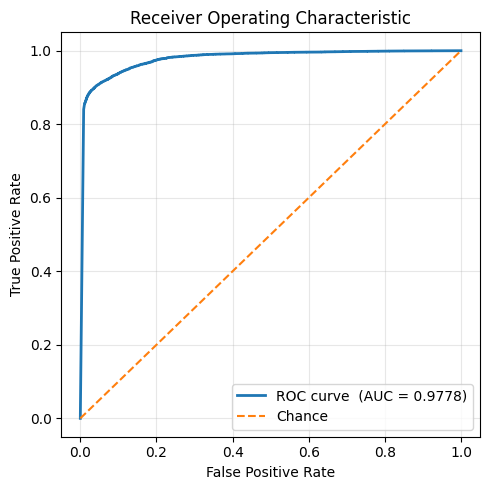

In [62]:
fpr, tpr, _ = roc_curve(y_true, y_score)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, linewidth=2,
         label=f"ROC curve  (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()

The loop prints the first 30 test-set positive edges, converting their integer node IDs back into the original GlobalId -> ProcessCapability pairs so we can verify what real relationships the model will be asked to predict.

In [ ]:
for i in range(30):
    u, v = test_pos_edges[i]
    print(le_gid.inverse_transform([u])[0], '-->', le_cap.inverse_transform([v - len(le_gid.classes_)])[0])


Graph Visualization

In [ ]:
edge_df

In [ ]:
edge_df['GlobalId'] = edge_df['GlobalId'].apply(lambda x: ast.literal_eval(x)[0])
edge_df

In [ ]:
edge_df['Source Color'] = '#def6ee'
edge_df['Destination Color'] = '#4bd738'
edge_df

In [ ]:
edge_df.rename(
    columns = {
        'GlobalId': 'Source',
        'ProcessCapability': 'Destination'
    },
    inplace = True
)
edge_df

In [ ]:
source_nodes = edge_df[['Source']].drop_duplicates().rename(columns={'Source': 'node'})
source_nodes['type'] = 'Source'

destination_nodes = edge_df[['Destination']].drop_duplicates().rename(columns={'Destination': 'node'})
destination_nodes['type'] = 'Destination'

node_df = pd.concat([source_nodes, destination_nodes], ignore_index=True)
node_df

In [ ]:
!pip install graphistry
import graphistry

In [ ]:
import pandas as pd
import graphistry

graphistry.register(api=3, server='hub.graphistry.com', username='jjvyas', password='Jinal@4502')

g = graphistry.edges(edge_df, source="Source", destination="Destination") \
    .nodes(node_df, node="node") \
    .bind(node="node") \
    .encode_point_color("type", categorical_mapping={'Source': 'orange', 'Destination': 'blue'}, as_categorical=True) \


In [ ]:
g.plot()